<div class="notebook-buttons" style="display:flex; padding-top: 5rem;padding-bottom: 2.5rem;line-height: 2.15;">
    <a href="https://colab.research.google.com/github/magdasalatka/fantasticfeatures/blob/main/how-to_synthetic-data.ipynb">
        <div id="colab-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; align-items: center;">
            <img class="call-to-action-img" src="img/colab.svg" width="30" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Run in Google Colab</div>
        </div>
    </a>
    <a href="https://raw.githubusercontent.com/magdasalatka/fantasticfeatures/main/how-to_synthetic-data.ipynb" download>
        <div id="download-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/download.svg" width="22" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Download Notebook</div>
        </div>
    </a>
    <a href="https://github.com/magdasalatka/fantasticfeatures/blob/main/how-to_synthetic-data.ipynb">
        <div id="github-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/github.svg" width="25" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">View on GitHub</div>
        </div>
    </a>
</div>

# How to generate synthetic data

by [Teresa Kubacka](http://teresa-kubacka.com/), [Magdalena Surówka](https://datali.ch)

AMLD 2021, 26.10.2021

In [3]:
!pip install -U git+https://github.com/magdasalatka/fantasticfeatures.git

  Cloning https://github.com/magdasalatka/fantasticfeatures.git to c:\users\tk\appdata\local\temp\pip-req-build-jvjjeijc


  Running command git clone -q https://github.com/magdasalatka/fantasticfeatures.git 'C:\Users\TK\AppData\Local\Temp\pip-req-build-jvjjeijc'
You should consider upgrading via the 'c:\users\tk\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from fantasticfeatures.dataset_noise_generator import *
from fantasticfeatures.plotting import *

from sklearn.datasets import make_regression

___

### How to generate synthetic data: 

Why work with synthetic data? There is no better way to understand how your modeling algorithm works than letting it do the work on the dataset where you know exactly what you should expect! 

In [3]:
# define num independent and num samples 
num_indep = 2
n_sample = 100

In [4]:
bias = 10 
custom_coef = [30,15]

Option 1: use sklearn `make_regression`

In [5]:
X_base, y, coeffs = make_regression(n_samples=n_sample, n_features=num_indep, n_informative=num_indep,
                       tail_strength=0, bias=bias, n_targets=1, noise=0, 
                           shuffle=False, coef=True, random_state=2)

In [6]:
coeffs

array([38.07925837, 17.83098278])

Option 2: use our `make_regression_custom`, where you can feed coefficients 

In [25]:
X_base, y_base, coeffs = make_regression_custom(n_samples=n_sample, n_features=num_indep, n_informative=num_indep,
                       tail_strength=0, bias=bias, n_targets=1, noise=0, 
                           shuffle=False, coef=True, random_state=2, custom_coef=custom_coef)

In [8]:
coeffs

array([30., 15.])

Option 3: from arbitrary X data, calculate a linear response: 

In [9]:
y_check = theoretical_function_linear(X_base, coeffs, bias=bias)

mean abs Y:  28.898885650208594
mean abs noise:  0.0
mean SNR:  inf


D:\ds_freelance\2021_amld_workshop\code\fantasticfeatures\fantasticfeatures\dataset_noise_generator.py:122: RuntimeWarning: divide by zero encountered in true_divide
  print('mean SNR: ',(np.abs(Y_base/noise_y)).mean())


You can use it in combination with Opt1 or Opt2. For example, generate first data using `make_regression*`, then add new columns with transformed data, then calculate new linear response out of transformed columns. 

Cross-check: How our X looks like? 

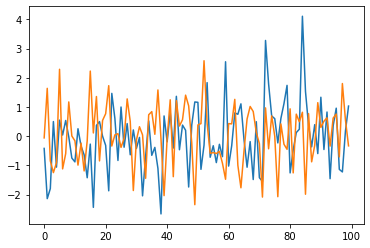

In [11]:
plt.plot(X_base)

___

### Adding synthetic errors (which typically would turn into residuals with a given distribution):

`gen_noise()` is a wrapper for generating random data, drawn from a particular distribution and scaled, based on a given input numpy array 

In [12]:
import inspect
print(inspect.getsource(gen_noise))

def gen_noise(input_X,noise_coeff,noise_type='normal', seed=99, clean_nan=True, **kw_opts): 
#     TODO: noise_coeff as a vector -> different for each channel

    
    
    np.random.seed(seed)
    shape = input_X.shape
    
    if len(shape)==1:
        shape = (shape[0],1) 
    
    if noise_type=='normal':
        if 'loc' not in kw_opts.keys():
            loc = 0
        else:
            loc = kw_opts['loc']
        noise = np.random.normal(loc,noise_coeff,shape)

    elif noise_type=='normal_prop':
        if 'loc' not in kw_opts.keys():
            loc = 0
        else:
            loc = kw_opts['loc']
        f = lambda x: np.random.normal(loc,np.abs(x.reshape(shape)),shape)
        noise = noise_coeff*f(input_X)

    elif noise_type=='poisson':
        noise = np.random.poisson(lam=np.abs(input_X),size=None)
        
    elif noise_type=='sin':
        try: 
            n_pi = kw_opts['n_osc']*2
        except:
            n_pi = 2 
        samples = np.linspace(0, n_pi*np.p

**gen_noise is fed with a pre-defined seed by default!!! use seed=None to not seed the generator**

Some examples: 

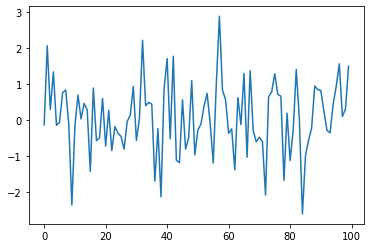

In [26]:
plt.plot(gen_noise(y_base, 1, 'normal'))

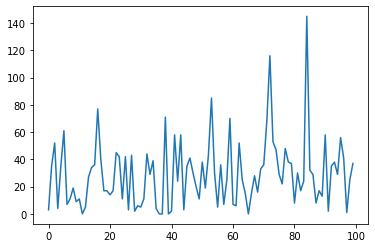

In [27]:
plt.plot(gen_noise(y_base, 1, 'poisson'))

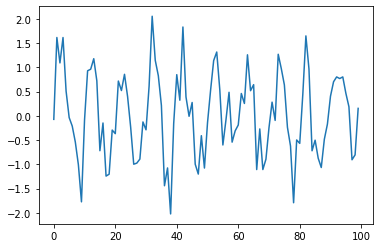

In [29]:
plt.plot(gen_noise(y_base, 1, 'sin', n_osc=10)+gen_noise(y_base, 0.5, 'normal'))

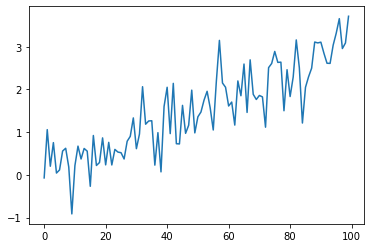

In [30]:
plt.plot(gen_noise(y_base, 3, 'linear_inc')+gen_noise(y_base, 0.5, 'normal'))

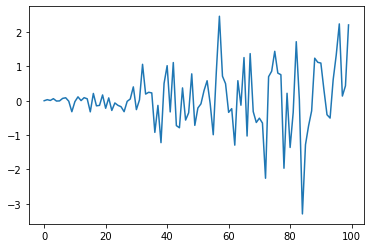

In [31]:
plt.plot(gen_noise(y_base, 3, 'linear_inc')*gen_noise(y_base, 0.5, 'normal'))

100.0
3


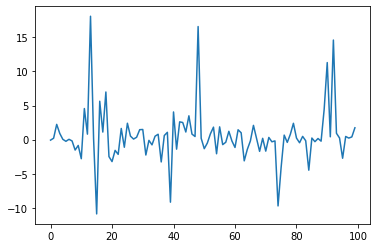

In [32]:
plt.plot(gen_noise(y_base, 1, 'cauchy',truncate=20))

(array([11., 23., 66.]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)

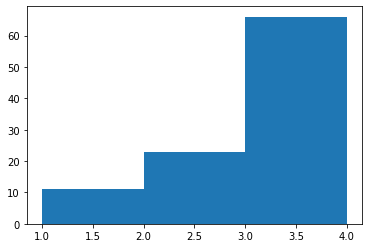

In [33]:
plt.hist(gen_noise(y_base, 1, 'population_weights', population=[1,2,3], weights=[0.1,0.2,0.7]),bins=[1,2,3,4])

In [36]:
# and a completely arbitrary noise ;D 
gen_noise(_,_,noise_type='lambda', func=np.random.normal, func_args={'loc':0, 'scale':1, 'size':10})

array([-0.14235884,  2.05722174,  0.28326194,  1.32981198, -0.15462185,
       -0.06903086,  0.75518049,  0.82564665, -0.11306921, -2.36783759])

Use these functions to add errors as you need. 

In [37]:
y = y_base + gen_noise(y_base, 1, 'normal')

___

There is also a little wrapper function to export the data to a dataframe

In [24]:
df = data_to_df(X,y)

Have fun! 